## Visualize Segmented Image with COCO .json File

In [1]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
coco = COCO('Gdansk Airport Labeling/1/instances_default.json')
img_dir = 'Gdansk Airport Labeling/1'
image_id = 6

img = coco.imgs[image_id]

img

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{'id': 6,
 'width': 1920,
 'height': 1024,
 'file_name': 'gdansk-supervideo-64px-00_09_10-00007.jpg',
 'license': 0,
 'flickr_url': '',
 'coco_url': '',
 'date_captured': 0}

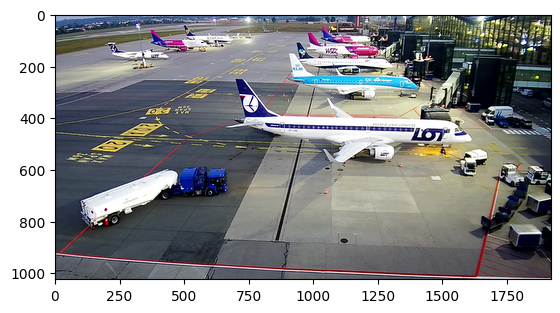

In [3]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='lanczos')
plt.show()

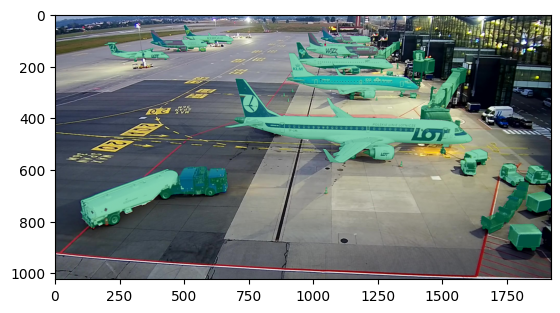

In [4]:
# See Overlay
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_id = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_id)
coco.showAnns(anns, draw_bbox=False)

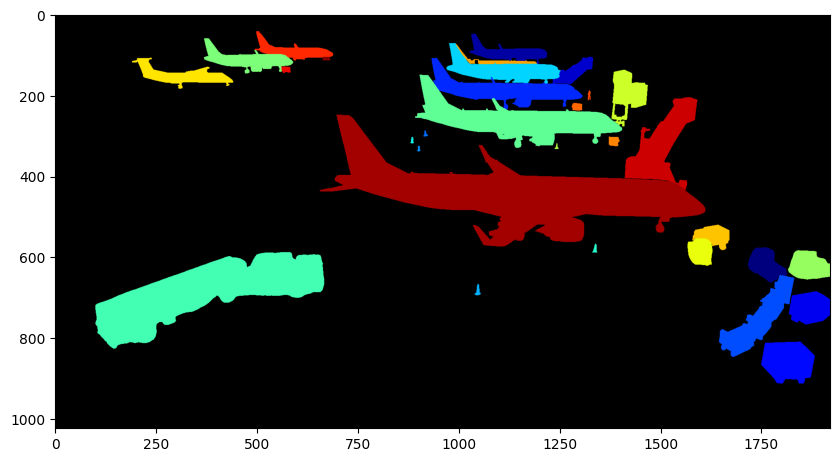

In [5]:
# See mask --- Different masks

# Create an empty mask
mask = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)

# Define colormap to use for the different masks
colors = plt.cm.jet(np.linspace(0,1,len(anns)))

for i, ann in enumerate(anns):
    # Get the mask for this annotation
    ann_mask = coco.annToMask(ann)

    # Use color defined by the colormap
    mask[ann_mask > 0] = (colors[i, :3]*255).astype(np.uint8)

# Display
plt.figure(figsize=(10,15))
plt.imshow(mask)
plt.show()

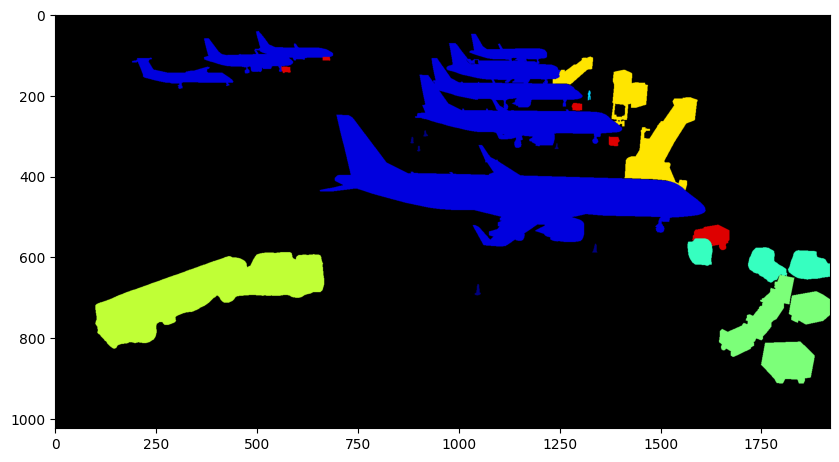

In [6]:
# See mask --- Different classes

# Create an empty mask
mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

# Define a colormap to use for the different category IDs
colors = plt.cm.jet(np.linspace(0, 1, len(cat_ids)))

color_map = {cat_id: colors[i] for i, cat_id in enumerate(cat_ids)}

for ann in anns:
    # Get the mask for this annotation
    ann_mask = coco.annToMask(ann)
    
    # Use the color defined by the category ID in the colormap
    mask[ann_mask > 0] = (color_map[ann['category_id']][:3] * 255).astype(np.uint8)

# Display the mask
plt.figure(figsize=(10,15))
plt.imshow(mask)
plt.show()

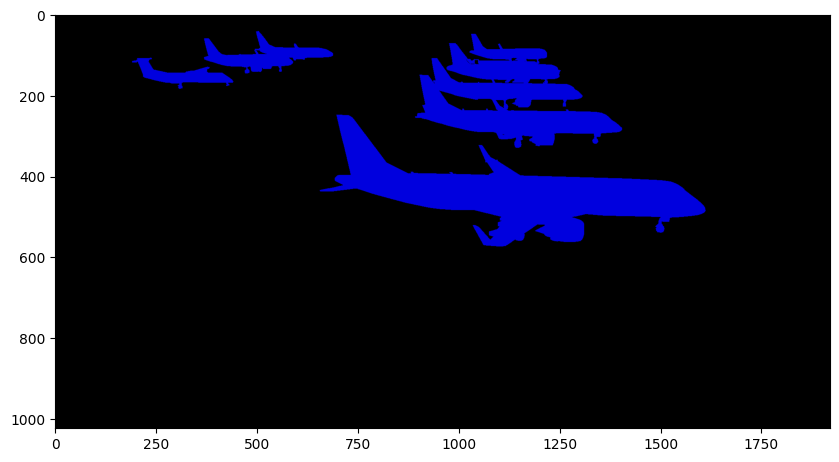

In [7]:
# Visuzlize any of the classes
mask = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)

for ann in anns:
    if ann['category_id'] == 2:
        ann_mask = coco.annToMask(ann)
        mask[ann_mask > 0] = (color_map[ann['category_id']][:3] * 255).astype(np.uint8)

plt.figure(figsize = (10,15))
plt.imshow(mask)
plt.show()

### Record 2D Location of each objects within a class for a given time-stamp and save it to csv

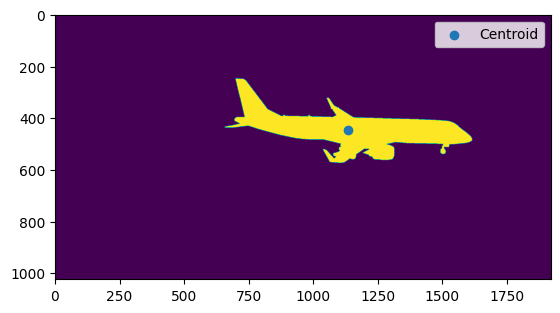

In [8]:
import cv2

def centroid(mask):
    '''Get the centroid of each object'''
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key = cv2.contourArea)
    M = cv2.moments(largest_contour)

    # Calculate centroid using the moments
    if M["m00"] != 0:
        position_x = int(M["m10"] / M["m00"])
        position_y = int(M["m01"] / M["m00"])
    else:
        position_x, position_y = 0, 0
    
    return position_x, position_y


plt.imshow(ann_mask)
x, y = centroid(ann_mask)
plt.scatter(x, y, label = 'Centroid')
plt.legend()
plt.show()

In [9]:
x,y

(1133, 444)

### Make Preliminary Dataset

In [7]:
import os
import pandas as pd 
from pycocotools.coco import COCO
import cv2
import numpy as np
from tqdm import tqdm



def centroid(mask):
    '''Get the centroid of each object'''
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key = cv2.contourArea)
    M = cv2.moments(largest_contour)

    # Calculate centroid using the moments
    if M["m00"] != 0:
        position_x = int(M["m10"] / M["m00"])
        position_y = int(M["m01"] / M["m00"])
    else:
        position_x, position_y = 0, 0
    
    return position_x, position_y


# Initialize a list to hold all the data
data = []

# Root directory
root_dir = 'Gdansk Airport Labeling'

# Loop over each subdirectory in the root directory
for subdir in tqdm(sorted(os.listdir(root_dir))):
    folder_path = os.path.join(root_dir, subdir)

    if os.path.isdir(folder_path):
        annotation_file = os.path.join(folder_path, 'instances_default.json')
        coco = COCO(annotation_file)
        
        # Get Category/Class labels
        cat_ids = coco.getCatIds()

        # Loop through each image in the subdirectory
        for i in range(len(coco.imgs)):
            img_id = coco.imgs[i+1]
            filename = img_id['file_name']
            Time_1 = filename[23:25]
            Time_2 = filename[26:28]
            Time_3 = filename[29:31]
            Sequence_ID = filename[32:37]


            anns_id = coco.getAnnIds(imgIds=img_id['id'], catIds=cat_ids, iscrowd=None) # All annotations in a single image
            anns = coco.loadAnns(anns_id) # dict inside a list [dict]

            # Loop through all the annotated objects in an image
            for ann in anns:
                object_class = ann['category_id']
                object_area = ann['area']
                object_id = ann['id']
                class_name = coco.loadCats(ann['category_id'])[0]['name']
                
                # Note: To get object_class name ---> coco.loadCats(ann['category_id'])

                # Get mask for this object
                object_mask = coco.annToMask(ann)
                
                # Get centroid
                centroid_x, centroid_y = centroid(object_mask)

                # Append the data to the list
                data.append({
                    'Time_1': Time_1,
                    'Time_2': Time_2,
                    'Time_3': Time_3,
                    'Sequence_ID': Sequence_ID,
                    'Object_Id': object_id,
                    'Object_Class': object_class,
                    'Class_Name': class_name,
                    'Centroid_x': centroid_x,
                    'Centroid_y': centroid_y,
                    'Object_Area': object_area                
                    })



# Convert the list of data to a pandas dataframe
df = pd.DataFrame(data)

# Export Data
df.to_csv('Gdansk_Airport_TimeSeries_Data.csv', index = False)

  0%|          | 0/3 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


 33%|███▎      | 1/3 [00:02<00:05,  2.58s/it]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


 67%|██████▋   | 2/3 [00:07<00:03,  3.86s/it]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 3/3 [00:09<00:00,  3.29s/it]


In [ ]:
import pandas as pd 
pd.set_option('display.max_rows', None)  # No limit on the number of rows displayed
pd.set_option('display.max_columns', None)
df = pd.read_csv('Gdansk_Airport_TimeSeries_Data.csv')
display(df)

### Web-scrape: Get Video Footage Gdansk (PPS-3 Camera)

In [2]:
import subprocess
import time

# Requires ffmepg to be installed under the hood

def record_stream(chunklist_url, duration, output_filename):
    '''
    Record a live HLS stream using given chunklist URL for a specified duration (seconds)
    '''
    command = [
        'ffmpeg',
        '-i', chunklist_url,
        '-t', str(duration),
        '-c', 'copy',
        output_filename
    ]

    # Run the ffmpeg command
    subprocess.run(command)

# This URL keeps changing everytime you load the webpage.
chunklist_url = 'https://62abe29de64ab.streamlock.net:4444/EPGD/pps3.stream/chunklist_w2096451211.m3u8'
record_duration = 60 #seconds
output_file = 'Gdansk_Live_Stream.mp4'

record_stream(chunklist_url, record_duration, output_file)


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab